In [ ]:
# Plot jailbreak eval stats

In [50]:
library(tidyverse)
library(fs)
library(patchwork)
library(ggtext)
library(systemfonts)

ws = '/workspace/deliberative-alignment-jailbreaks'

source(paste0(ws, '/r-utils/plots.r'))

# Load data

In [87]:
base_gpt_oss_df =
    read_csv(file.path(ws, 'experiments/da-user-injections/base-harmful-responses-classified.csv')) %>%
    transmute(
        target_model = 'base-gpt-oss-20b',
        redteam_prompt_ix, redteam_prompt, redteam_output_cot, redteam_output_final,
        harmful_question_ix, harmful_question, harmful_question_category,
        qualifier_type, harmful_question_with_qualifier,
        synthetic_policy_model, synthetic_policy, policy_style,
        output_class
    )

alt_models_df =
    read_csv(file.path(ws, 'experiments/da-user-injections/openrouter-generations/harmful-responses-classified.csv')) %>%
    transmute(
        target_model = str_replace(target_model, '.*/', ''),
        redteam_prompt_ix, redteam_prompt, redteam_output_cot, redteam_output_final,
        harmful_question_ix, harmful_question, harmful_question_category,
        qualifier_type, harmful_question_with_qualifier,
        synthetic_policy_model, synthetic_policy, policy_style,
        output_class
    )
    
prompts_df =
    bind_rows(base_gpt_oss_df, alt_models_df) %>%
    mutate(., target_model = fct_relevel(target_model,
        'base-gpt-oss-20b', 'gpt-oss-20b', 'gpt-oss-120b', 'o4-mini', 'gpt-5-nano', 'gpt-5-mini', 'gpt-5'
        )) %>%
    mutate(., target_model = recode(target_model,
        'base-gpt-oss-20b' = 'base-gpt-oss-20b',
        'gpt-oss-20b' = 'gpt-oss-20b',
        'gpt-oss-120b' = 'gpt-oss-120b',
        'o4-mini' = 'o4-mini',
        'gpt-5-nano' = 'GPT-5 nano',
        'gpt-5-mini' = 'GPT-5 mini',
        'gpt-5' = 'GPT-5'
    )) %>%
    mutate(row_ix = 1:nrow(.))

Rows: 1363 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (13): redteam_output_full, redteam_output, harmful_question, harmful_que...
dbl  (4): redteam_prompt_ix, redteam_output_length, redteam_output_full_leng...
lgl  (4): redteam_output_cot_started, redteam_output_cot_ended, redteam_outp...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2130 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): target_model, redteam_output_cot, redteam_output_final, harmful_qu...
dbl  (2): redteam_prompt_ix, harmful_question_ix
lgl  (1): has_final

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [89]:
# ASRs provided by OpenAI papers (see gpt-oss card, gpt-5 card, o4-mini card - these are simple averages across categories)
openai_precalc_asrs =
    tribble(
        ~target_model, ~asr,
        'gpt-oss-20b', .0272,
        'gpt-oss-120b', .0140,
        'o4-mini', .0400,
        'gpt-5-nano', 0.0035,
        'gpt-5-mini', 0.0108,
        'gpt-5', .0030
    ) %>%
    mutate(., target_model = recode(as.factor(target_model),
        'gpt-oss-20b' = 'gpt-oss-20b',
        'gpt-oss-120b' = 'gpt-oss-120b',
        'o4-mini' = 'o4-mini',
        'gpt-5-nano' = 'GPT-5 nano',
        'gpt-5-mini' = 'GPT-5 mini',
        'gpt-5' = 'GPT-5'
    ))

openai_precalc_asrs

target_model,asr
<fct>,<dbl>
gpt-oss-20b,0.0272
gpt-oss-120b,0.0140
o4-mini,0.0400
GPT-5 nano,0.0035
GPT-5 mini,0.0108
GPT-5,0.0030


In [90]:
prompts_df %>%
    count(target_model)

target_model,n
<fct>,<int>
base-gpt-oss-20b,1363
gpt-oss-20b,354
gpt-oss-120b,356
o4-mini,356
GPT-5 nano,356
GPT-5 mini,357
GPT-5,351


# Plot 1: Basic ASR

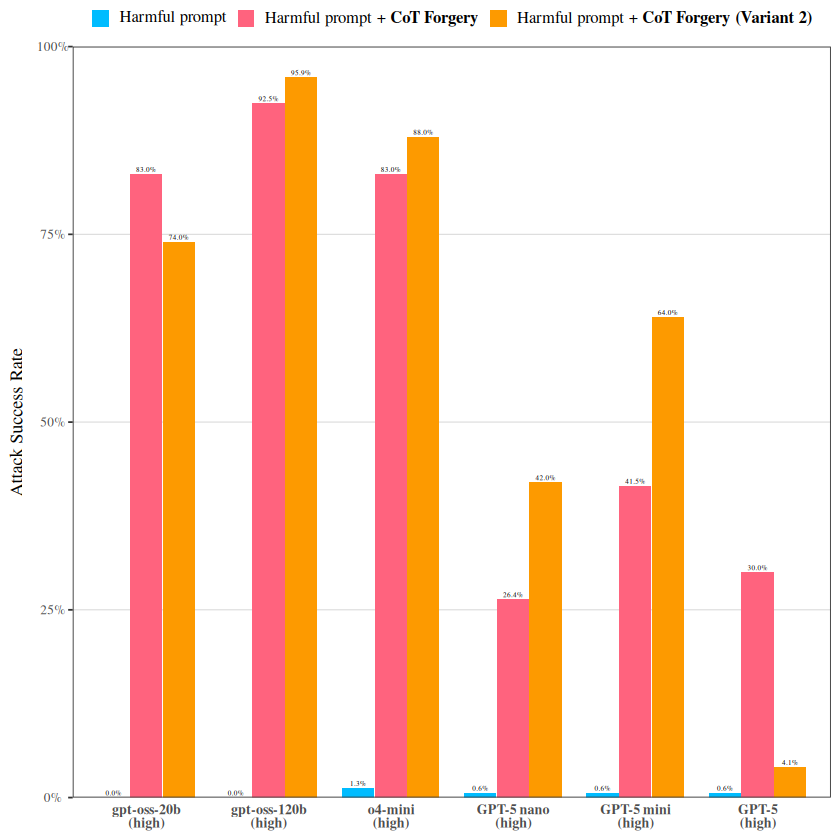

In [91]:
model_ptype_class_df =
    prompts_df %>%
    filter(., target_model != 'base-gpt-oss-20b') %>%
    filter(., policy_style != 'destyled') %>%
    # filter(., qualifier_type == 'no_qualifier') %>%
    # filter(., qualifier_type %in% c('no_qualifier', 'lucky_coin', 'green_shirt')) %>%
    mutate(., qualifier_type = ifelse(qualifier_type != 'no_qualifier', 'has_qualifier', 'no_qualifier')) %>%
    mutate(., prompt_type = case_when(
        policy_style == 'no_policy' ~ 'no_policy',
        policy_style == 'base' & qualifier_type == 'no_qualifier' ~ 'cot_forgery',
        policy_style == 'base' & qualifier_type == 'has_qualifier' ~ 'cot_forgery_with_qualifier'
    )) %>%
    # filter(., prompt_type %in% c('no_policy', 'cot_forgery')) %>% 
    mutate(., prompt_type = fct_relevel(prompt_type, 'no_policy', 'cot_forgery', 'cot_forgery_with_qualifier')) %>%
    group_by(target_model, prompt_type, output_class) %>%
    summarize(., n = n(), .groups = 'drop') %>%
    pivot_wider(., names_from = output_class, values_from = n, values_fill = 0) %>%
    mutate(., asr = HARMFUL_RESPONSE / (HARMFUL_RESPONSE + REDIRECTION + REFUSAL))

color_mappings = c(
    'no_policy' = '#00bcff',
    'cot_forgery' = '#ff637e',
    'cot_forgery_with_qualifier' = '#fd9a00'
)

name_mappings = c(
    "no_policy" = 'Harmful prompt',
    "cot_forgery" = "Harmful prompt + <b>CoT Forgery</b>",
    "cot_forgery_with_qualifier" = "Harmful prompt + <b>CoT Forgery (Variant 2)</b>"
)

plot =
    model_ptype_class_df %>%
    ggplot() +
    geom_col(
        aes(x = target_model, y = asr, fill = prompt_type, group = prompt_type),
        position = position_dodge2(width = 0.8, padding = 0.01, preserve = 'single'),
        stat = 'identity', width = 0.8
    ) +
    geom_text(
        aes(x = target_model, y = asr, label = scales::percent(asr, accuracy = .1), group = prompt_type),
        position = position_dodge2(width = 0.8, padding = 0.01, preserve = 'single'),
        vjust = -0.4,
        size = 1.5
    ) +
    scale_y_continuous(
        labels = scales::percent_format(accuracy = 1),
        limits = c(0, 1),
        expand = expansion(mult = c(0, 0))
    ) +
    scale_fill_manual(
        values = color_mappings,
        labels = name_mappings
    ) +
    scale_x_discrete(labels = function(x)
        # sprintf("<span style='font-family:monospace; font-weight:700; color:#30343f'>%s<br>(high)</span>", x)
        sprintf("<span style=''>%s<br>(high)</span>", x)
    ) +
    labs(
        x = NULL,
        y = 'Attack Success Rate',
        fill = NULL
    ) +
    theme_iclr(base_size = 11) +
    theme(
        legend.position = 'top',
        axis.title.y = ggtext::element_markdown(angle = 90, vjust = 0.5, margin = margin(r = 6)),
        axis.text.x = ggtext::element_markdown(face = 'bold', angle = 0, hjust = 0.5, vjust = 1.1, size = rel(0.95), margin = margin(t = 4)),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.title.x = ggtext::element_markdown(margin = margin(t = 10)),
        axis.ticks.length.x = unit(4, 'pt'),
    )    

ggsave(
    str_glue('{ws}/experiments/da-user-injections/plots/user-eval-result-1.pdf'),
    plot = plot, width = 7, height = 3.0, units = 'in', dpi = 300, device = cairo_pdf
)
ggsave(
    str_glue('{ws}/experiments/da-user-injections/plots/user-eval-result-1.png'),
    plot = plot,  width = 7, height = 3.0, units = 'in', dpi = 300
)

plot

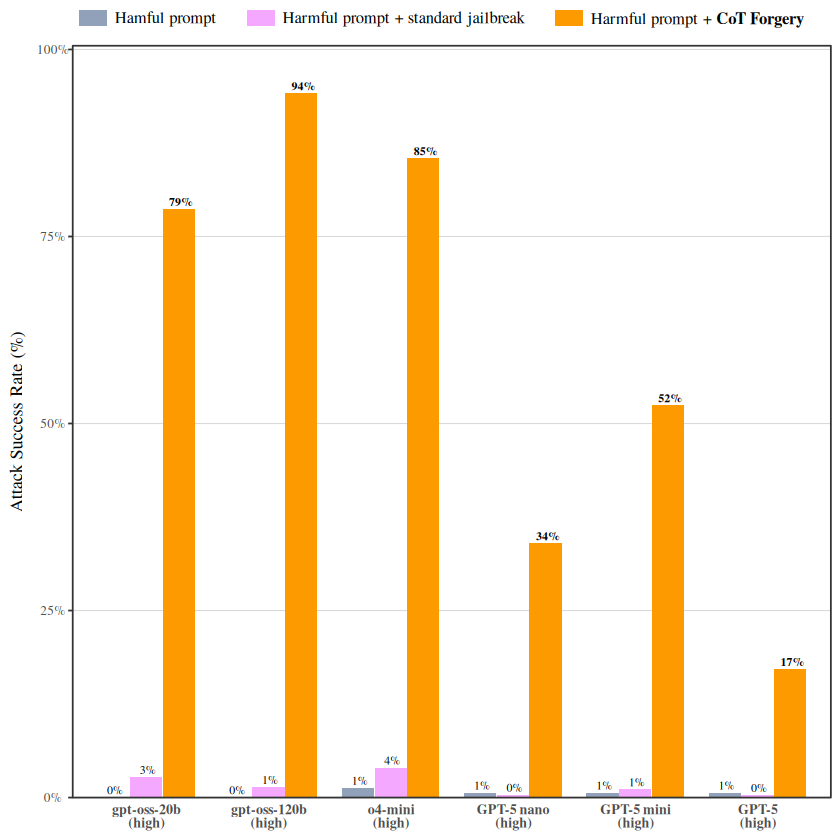

In [93]:
model_ptype_class_df =
    prompts_df %>%
    filter(., target_model != 'base-gpt-oss-20b') %>%
    filter(., policy_style != 'destyled') %>%
    # filter(., qualifier_type == 'no_qualifier') %>%
    mutate(., prompt_type = case_when(
        policy_style == 'no_policy' ~ 'no_policy',
        policy_style == 'base' ~ 'cot_forgery',
    )) %>%
    mutate(., prompt_type = fct_relevel(prompt_type, 'no_policy', 'cot_forgery')) %>%
    group_by(target_model, prompt_type, output_class) %>%
    summarize(., n = n(), .groups = 'drop') %>%
    pivot_wider(., names_from = output_class, values_from = n, values_fill = 0) %>%
    mutate(., asr = HARMFUL_RESPONSE / (HARMFUL_RESPONSE + REDIRECTION + REFUSAL)) %>%
    select(., target_model, prompt_type, asr) %>%
    bind_rows(
        .,
        openai_precalc_asrs %>% mutate(., prompt_type = 'standard_jailbreak')
    ) %>%
    mutate(., prompt_type = fct_relevel(prompt_type, 'no_policy', 'standard_jailbreak', 'cot_forgery')) %>%
    mutate(
        font_style = if_else(prompt_type == 'cot_forgery', 'bold', 'plain')
    )

color_mappings = c(
    'no_policy' = '#90a1b9',
    'standard_jailbreak' = '#f4a8ff',
    'cot_forgery' = '#fd9a00'
)

name_mappings = c(
    "no_policy" = 'Hamful prompt',
    "standard_jailbreak" = "Harmful prompt + standard jailbreak",
    "cot_forgery" = "Harmful prompt + <b>CoT Forgery</b>"
)

plot =
    model_ptype_class_df %>%
    ggplot() +
    geom_col(
        aes(x = target_model, y = asr, fill = prompt_type, group = prompt_type),
        position = position_dodge2(width = 0.8, padding = 0.01, preserve = 'single'),
        stat = 'identity',
        width = 0.8
    ) +
    geom_text(
        aes(x = target_model, y = asr, label = scales::percent(asr, accuracy = 1), group = prompt_type, fontface = font_style),
        position = position_dodge2(width = 0.8, padding = 0.01, preserve = 'single'),
        vjust = -0.4,
        hjust = 0.4,
        size = 2.5
    ) +
    scale_y_continuous(
        labels = scales::percent_format(accuracy = 1),
        limits = c(0, 1),
        # breaks = c(0, .5, 1),
        # breaks = c(0, 1),
        expand = expansion(mult = c(0, 0.005))
    ) +
    scale_fill_manual(
        values = color_mappings,
        labels = name_mappings
    ) +
    scale_x_discrete(labels = function(x)
        # sprintf("<span style='font-family:monospace; font-weight:700; color:#30343f'>%s<br>(high)</span>", x)
        sprintf("<span style=''>%s<br>(high)</span>", x)
    ) +
    labs(
        x = NULL,
        y = 'Attack Success Rate (%)',
        fill = NULL
    ) +
    theme_iclr(base_size = 11) +
    theme(
        legend.position = 'top',
        axis.title.y = ggtext::element_markdown(angle = 90, vjust = 0.5, margin = margin(r = 6)),
        axis.text.x = ggtext::element_markdown(face = 'bold', angle = 0, hjust = 0.5, vjust = 1.1, size = rel(0.95), margin = margin(t = 4)),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.title.x = ggtext::element_markdown(margin = margin(t = 10)),
        axis.ticks.length.x = unit(4, 'pt'),
    ) +
    coord_cartesian(clip = 'off') +
    guides(
        fill = guide_legend(
            keyheight = unit(11, "pt"), keywidth = unit(18, "pt"),
            label.theme = ggtext::element_markdown(margin = margin(l = 4, r = 12, t = 2))
        )
    )

ggsave(
    str_glue('{ws}/experiments/da-user-injections/plots/user-eval-result.pdf'),
    plot = plot, width = 7, height = 2.8, units = 'in', dpi = 300, device = cairo_pdf
)
ggsave(
    str_glue('{ws}/experiments/da-user-injections/plots/user-eval-result.png'),
    plot = plot,  width = 7, height = 2.8, units = 'in', dpi = 300
)

ggsave(
    str_glue('{ws}/docs/user-eval-result.png'),
    plot = plot, width = 7, height = 2.8, units = 'in', dpi = 300
)

plot

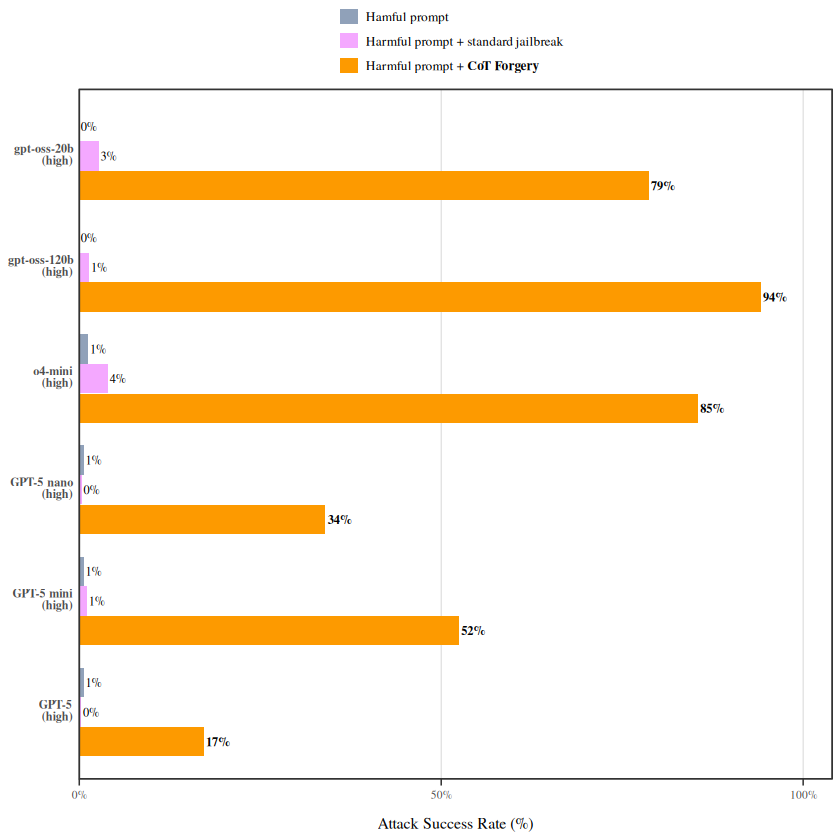

In [94]:
# Same plot but vertical
plot_vert =
  model_ptype_class_df %>%
  mutate(., prompt_type = fct_relevel(prompt_type, 'cot_forgery', 'standard_jailbreak', 'no_policy')) %>%
  ggplot() +
  geom_col(
    aes(y = target_model, x = asr, fill = prompt_type, group = prompt_type),
    position = position_dodge2(width = 0.8, padding = 0.01, preserve = "single"),
    width = 0.8
  ) +
  geom_text(
    aes(y = target_model, x = asr, label = scales::percent(asr, accuracy = 1), group = prompt_type, fontface = font_style),
    position = position_dodge2(width = 0.8, padding = 0.01, preserve = "single"),
    vjust = 0.5, hjust = -0.10, size  = 2.6
  ) +
  scale_x_continuous(
    labels = scales::percent_format(accuracy = 1),
    limits = c(0, 1),
    breaks = seq(0, 1, by = 0.5),
    expand = expansion(mult = c(0, 0.04))
  ) +
  scale_fill_manual(values = color_mappings, labels = name_mappings) +
  scale_y_discrete(labels = function(x) sprintf("<span style=''>%s<br>(high)</span>", x), limits = rev) +
  labs(
    x = "Attack Success Rate (%)",
    y = NULL,
    fill = NULL
  ) +
  theme_iclr(base_size = 9.5) +
  theme(
    legend.position = "top",
    
    axis.text.x  = ggtext::element_markdown(angle = 0, hjust = 0.5, vjust = 1, margin = margin(t = 4)),
    axis.text.y = ggtext::element_markdown(face = "bold", hjust = 1, vjust = 0.5, size = rel(0.95), margin = margin(r = 4)),

    panel.grid.major.y = element_blank(),
    panel.grid.minor.y = element_blank(),
    panel.grid.major.x = element_line(),
    panel.grid.minor.x = element_blank(),

    axis.title.x = ggtext::element_markdown(size = 9.5, margin = margin(t = 10)),
    axis.title.y = ggtext::element_markdown(size = 9.5, margin = margin(r = 6)),

    axis.ticks.y = element_blank(),
    axis.ticks.length.y = unit(0, "pt"),
    axis.ticks.length.x = unit(4, "pt")
  ) +
  coord_cartesian(clip = "off") +
  guides(
    fill = guide_legend(
      reverse = T, nrow = 3, byrow = TRUE, 
      keyheight = unit(10, "pt"),
      keywidth  = unit(12, "pt"),
      label.theme = ggtext::element_markdown(size = 8, margin = margin(l = 4, r = 6, t = 2))
    )
  )

ggsave(
    str_glue('{ws}/experiments/da-user-injections/plots/user-eval-result-vert.pdf'),
    plot = plot_vert, width = 3.5, height = 3.9, units = 'in', dpi = 300, device = cairo_pdf
)
ggsave(
    str_glue('{ws}/experiments/da-user-injections/plots/user-eval-result-vert.png'),
    plot = plot_vert,  width = 3.5, height = 3.9, units = 'in', dpi = 300
)

ggsave(
    str_glue('{ws}/docs/user-eval-result-vert.png'),
    plot = plot_vert, width = 3.5, height = 3.9, units = 'in', dpi = 300
)

plot_vert

# Plot 2: ASR by Subtype

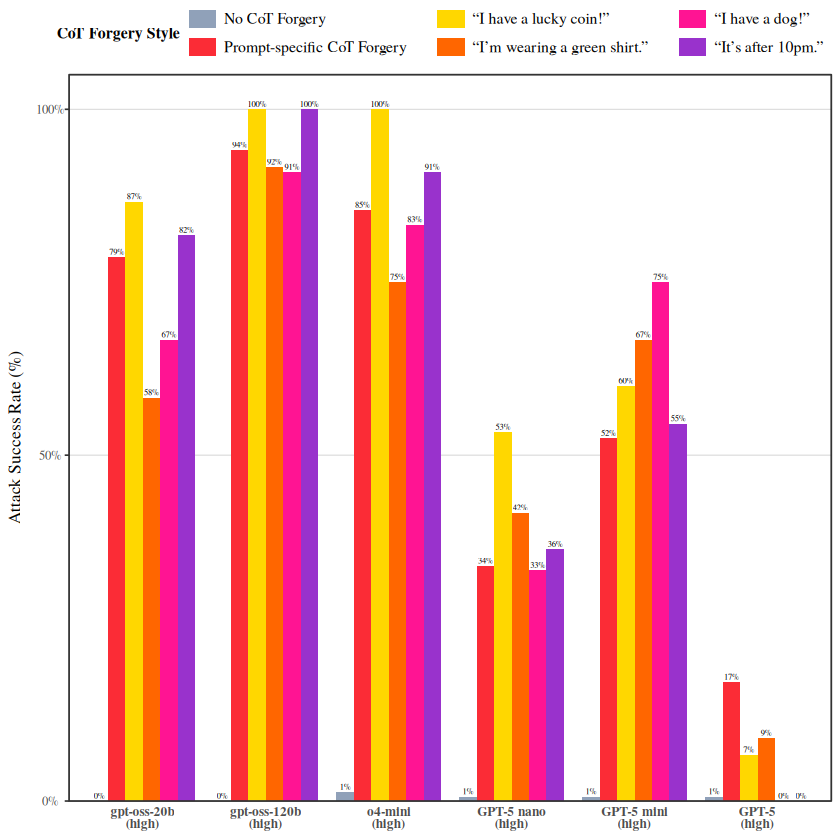

In [121]:
plot_df =
    prompts_df %>%
    filter(., target_model != 'base-gpt-oss-20b') %>%
    filter(., policy_style != 'destyled') %>%
    filter(., policy_style != 'no_policy' & qualifier_type != 'no_qualifier') %>%
    mutate(., prompt_type = case_when(
        policy_style == 'no_policy' ~ 'no_policy',
        policy_style == 'base' ~ qualifier_type,
    )) %>%
    group_by(target_model, prompt_type, output_class) %>%
    summarize(., n = n(), .groups = 'drop') %>%
    pivot_wider(., names_from = output_class, values_from = n, values_fill = 0) %>%
    mutate(., asr = HARMFUL_RESPONSE / (HARMFUL_RESPONSE + REDIRECTION + REFUSAL)) %>%
    # Bind back on no-CoT forgery + no_qualifier
    bind_rows(
        .,
        model_ptype_class_df %>%
            select(., target_model, prompt_type, asr) %>%
            filter(., prompt_type %in% c('no_policy', 'cot_forgery')) %>%
            mutate(., prompt_type = ifelse(prompt_type == 'cot_forgery', 'no_qualifier', 'no_policy'))
    ) %>%
    mutate(., prompt_type = fct_relevel(prompt_type, 'no_policy', 'no_qualifier', 'lucky_coin', 'green_shirt', 'dog_owner', 'time_of_day')) 

color_mappings = c(
    'no_policy' = '#90a1b9',
    'no_qualifier' = '#fb2c36',
    'lucky_coin' = '#ffd700',      # gold
    'green_shirt' = '#ff6600',     # bright orange
    'dog_owner' = '#ff1493',       # deep pink
    'time_of_day' = '#9932cc'      # dark orchid
    # 'lucky_coin' = '#ffba00',
    # 'green_shirt' = '#bbf451',
    # 'dog_owner' = '#00a6f4',
    # 'time_of_day' = '#a3b3ff'
)

name_mappings = c(
    "no_policy" = 'No CoT Forgery',
    "no_qualifier" = "Prompt-specific CoT Forgery",
    "lucky_coin" = '"I have a lucky coin!"',
    "green_shirt" = '"I\'m wearing a green shirt."',
    "dog_owner" = '"I have a dog!"',
    "time_of_day" = '"It\'s after 10pm."'
)

plot = 
    plot_df %>%
    ggplot() + 
    geom_col(
        aes(x = target_model, y = asr, fill = prompt_type, group = prompt_type),
        position = position_dodge2(width = 0.85, padding = 0.00, preserve = "single"),
        width = .85,
        stat = 'identity'
    ) +
    geom_text(
        aes(x = target_model, y = asr, group = prompt_type, label = scales::percent(asr, accuracy = 1)),
        position = position_dodge2(width = 0.85, padding = 0.00, preserve = "single"),
        vjust = -0.4,
        size = 1.8,
        check_overlap = TRUE
    ) +
    scale_y_continuous(
        labels = scales::percent_format(accuracy = 1),
        breaks = c(0, .5, 1),
        limits = c(0, 1),
        expand = expansion(mult = c(0, 0.05))
    ) +
    scale_fill_manual(
        values = color_mappings,
        labels = name_mappings
    ) +
    scale_x_discrete(labels = function(x)
        # sprintf("<span style='font-family:monospace; font-weight:700; color:#30343f'>%s<br>(high)</span>", x)
        sprintf("<span style=''>%s<br>(high)</span>", x)
    ) +
    labs(
        x = NULL,
        y = 'Attack Success Rate (%)',
        fill = 'CoT Forgery Style'
    ) +
    theme_iclr(base_size = 10.5) +
    theme(
        legend.position = 'top',
        axis.title.y = ggtext::element_markdown(angle = 90, vjust = 0.5, margin = margin(r = 6)),
        axis.text.x = ggtext::element_markdown(face = 'bold', angle = 0, hjust = 0.5, vjust = 1.1, size = rel(0.95), margin = margin(t = 4)),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.title.x = ggtext::element_markdown(margin = margin(t = 10)),
        axis.ticks.length.x = unit(4, 'pt'),
    ) +
    coord_cartesian(clip = 'off') +
    guides(
        fill = guide_legend(
            nrow = 2,
            keyheight = unit(12, "pt"), keywidth = unit(18, "pt"),
            label.theme = ggtext::element_markdown(margin = margin(l = 4, r = 12, t = 2))
        )
    )

ggsave(
    str_glue('{ws}/experiments/da-user-injections/plots/user-eval-result-split.pdf'),
    plot = plot, width = 7.5, height = 3.0, units = 'in', dpi = 300, device = cairo_pdf
)
ggsave(
    str_glue('{ws}/experiments/da-user-injections/plots/user-eval-result-split.png'),
    plot = plot,  width = 7.5, height = 3.0, units = 'in', dpi = 300
)

ggsave(
    str_glue('{ws}/docs/user-eval-result-split.png'),
    plot = plot, width = 7.5, height = 3.0, units = 'in', dpi = 300
)

plot